# 09_02: Fitting models

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

In [2]:
gm = pd.read_csv('gapminder.csv', dtype_backend='pyarrow')

In [3]:
gm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41822 entries, 0 to 41821
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   country           41822 non-null  string[pyarrow]
 1   year              41822 non-null  int64[pyarrow] 
 2   region            41822 non-null  string[pyarrow]
 3   population        41822 non-null  double[pyarrow]
 4   life_expectancy   40629 non-null  double[pyarrow]
 5   age5_surviving    40490 non-null  double[pyarrow]
 6   babies_per_woman  41822 non-null  double[pyarrow]
 7   gdp_per_capita    41822 non-null  double[pyarrow]
dtypes: double[pyarrow](5), int64[pyarrow](1), string[pyarrow](2)
memory usage: 2.8 MB


In [4]:
gdata = gm[gm.year == 1985].copy()

In [5]:
gdata['region'] = gdata['region'].astype('category')

In [6]:
gdata.region.dtype

CategoricalDtype(categories=['Africa', 'America', 'Asia', 'Europe', 'Oceania'], ordered=False, categories_dtype=string[pyarrow])

In [7]:
continent = gdata.region.map({'Africa': 'skyblue', 'Europe': 'gold', 'America': 'palegreen', 'Asia': 'coral', 'Oceania': 'teal'})
population = 1e-6 * gdata.population

def plotbabies():    
    gdata.plot.scatter('age5_surviving', 'babies_per_woman', c=continent, s=population,
                       linewidths=0.5, edgecolor='black', alpha=0.6, figsize=(5,3.5)); # alpha adds some transparency

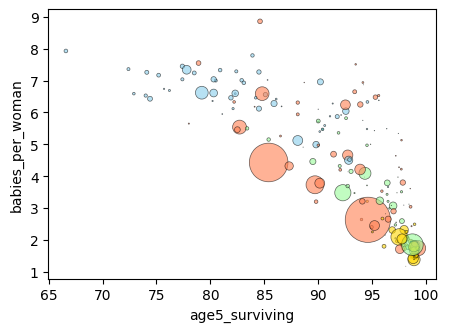

In [8]:
plotbabies()

In [9]:
import statsmodels
import statsmodels.formula.api as smf

In [10]:
constantmodel = smf.ols(formula='babies_per_woman ~ 1', data=gdata)

In [11]:
constantfit = constantmodel.fit()

In [12]:
constantfit.params

Intercept    4.296
dtype: float64

In [13]:
gdata.babies_per_woman.mean()

4.296

In [14]:
constantfit.predict(gdata)

169      4.296
393      4.296
617      4.296
828      4.296
1052     4.296
         ...  
40930    4.296
41153    4.296
41351    4.296
41575    4.296
41783    4.296
Length: 195, dtype: float64

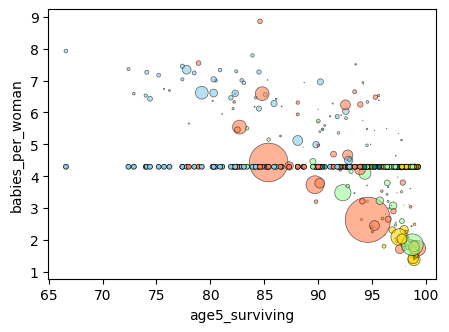

In [15]:
plotbabies()
pp.scatter(gdata.age5_surviving, constantfit.predict(gdata), color=continent,
           s=50, marker='.', edgecolor='k', linewidth=0.5); # small square markers with a think black edge

In [16]:
groupfit = smf.ols(formula='babies_per_woman ~ 1 + region', data=gdata).fit()

In [17]:
groupfit.params

Intercept            6.326296
region[T.America]   -2.745153
region[T.Asia]      -1.779896
region[T.Europe]    -4.440820
region[T.Oceania]   -1.737011
dtype: float64

In [18]:
groupfit2 = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit()

In [19]:
groupfit2.params

region[Africa]     6.326296
region[America]    3.581143
region[Asia]       4.546400
region[Europe]     1.885476
region[Oceania]    4.589286
dtype: float64

In [20]:
gdata.groupby('region', observed=True).babies_per_woman.mean()

region
Africa     6.326296
America    3.581143
Asia         4.5464
Europe     1.885476
Oceania    4.589286
Name: babies_per_woman, dtype: double[pyarrow]

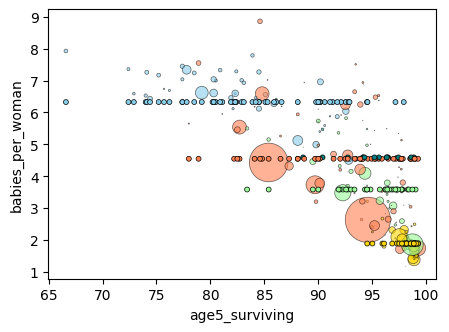

In [21]:
plotbabies()
pp.scatter(gdata.age5_surviving, groupfit2.predict(gdata), color=continent,
           s=50, marker='.', ec='k', lw=0.5);

In [22]:
survivingfit = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=gdata).fit()

In [23]:
survivingfit.params

region[Africa]     19.213674
region[America]    18.130077
region[Asia]       18.690979
region[Europe]     16.947616
region[Oceania]    19.156939
age5_surviving     -0.153428
dtype: float64

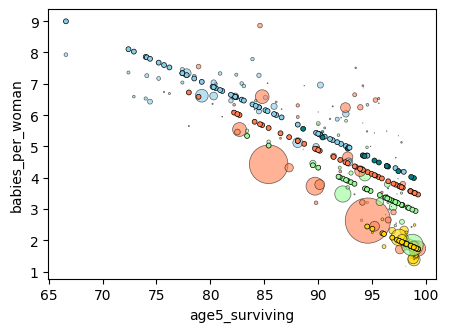

In [24]:
plotbabies()
pp.scatter(gdata.age5_surviving, survivingfit.predict(gdata), color=continent,
           s=50, marker='.', ec='k', lw=0.5);

In [25]:
survivingfit2 = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region', data=gdata).fit()

In [26]:
survivingfit2.params

region[Africa]                    15.366983
region[America]                   26.928167
region[Asia]                      22.463712
region[Europe]                    25.025887
region[Oceania]                   27.781741
age5_surviving:region[Africa]     -0.107632
age5_surviving:region[America]    -0.246209
age5_surviving:region[Asia]       -0.194351
age5_surviving:region[Europe]     -0.235716
age5_surviving:region[Oceania]    -0.244265
dtype: float64

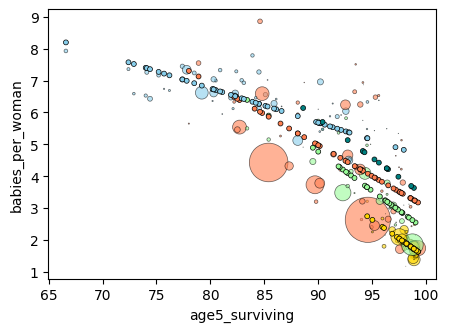

In [27]:
plotbabies()
pp.scatter(gdata.age5_surviving, survivingfit2.predict(gdata), color=continent,
           s=50, marker='.', ec='k', lw=0.5);

In [28]:
twovariablefit = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region + population', data=gdata).fit()

In [29]:
twovariablefit.params

region[Africa]                    1.541442e+01
region[America]                   2.672689e+01
region[Asia]                      2.300482e+01
region[Europe]                    2.482028e+01
region[Oceania]                   2.767984e+01
age5_surviving:region[Africa]    -1.079450e-01
age5_surviving:region[America]   -2.436776e-01
age5_surviving:region[Asia]      -1.989314e-01
age5_surviving:region[Europe]    -2.332709e-01
age5_surviving:region[Oceania]   -2.431548e-01
population                       -2.044145e-09
dtype: float64

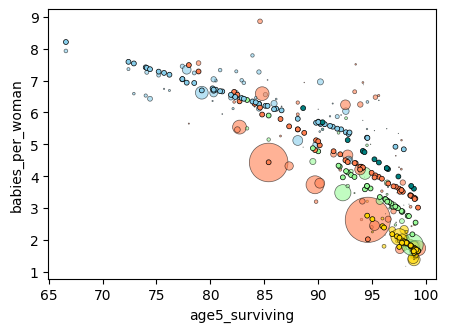

In [30]:
plotbabies()
pp.scatter(gdata.age5_surviving, twovariablefit.predict(gdata), color=continent,
           s=50, marker='.', ec='k', lw=0.5);